# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

In [2]:
#Cargar los datos 
taxi = pd.read_csv('taxi.csv')

In [3]:
print(taxi.head())

              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32


In [4]:
#Convertir la columna datatime al tipo de datos datatime
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
#Remuestrea los datos por hora
taxi.set_index('datetime', inplace=True)
taxi_hour = taxi.resample('H').sum().reset_index()
print(taxi_hour.head())

             datetime  num_orders
0 2018-03-01 00:00:00         124
1 2018-03-01 01:00:00          85
2 2018-03-01 02:00:00          71
3 2018-03-01 03:00:00          66
4 2018-03-01 04:00:00          43


## Análisis

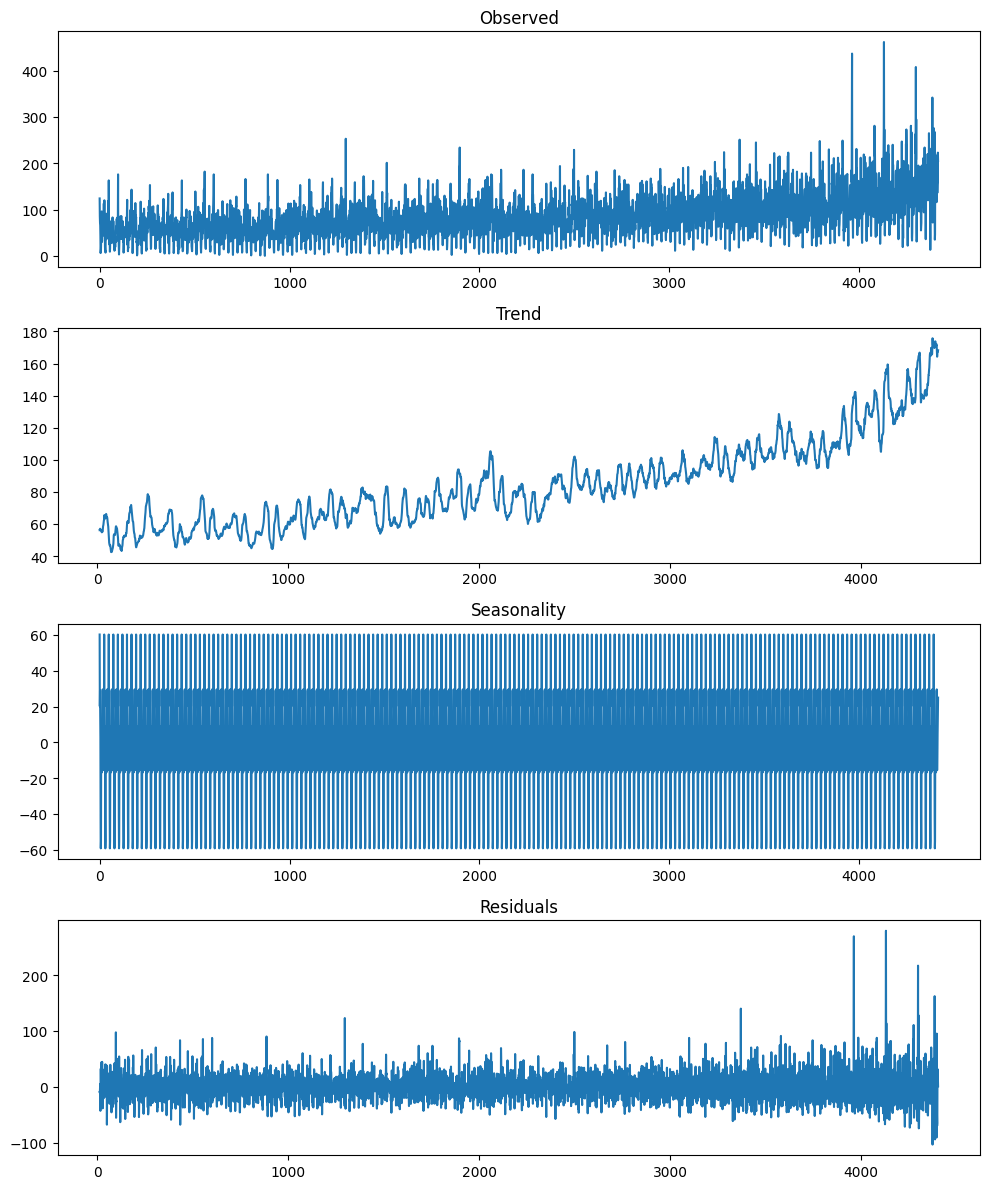

In [6]:
# Análisis de tendencia y estacionalidad 
decomposed = seasonal_decompose(taxi_hour['num_orders'], model='additive', period=24)

plt.figure(figsize=(10,12))

plt.subplot(411)
decomposed.observed.plot(ax=plt.gca())
plt.title('Observed')

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

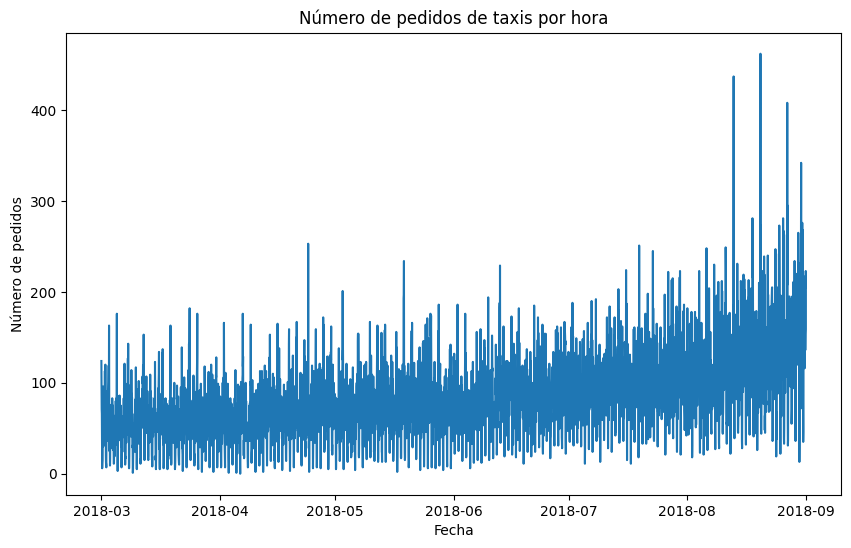

                  datetime   num_orders
count                 4416  4416.000000
mean   2018-05-31 23:30:00    84.422781
min    2018-03-01 00:00:00     0.000000
25%    2018-04-15 23:45:00    54.000000
50%    2018-05-31 23:30:00    78.000000
75%    2018-07-16 23:15:00   107.000000
max    2018-08-31 23:00:00   462.000000
std                    NaN    45.023853


In [7]:
# Visualización de la serie temporal
plt.figure(figsize=(10, 6))
plt.plot(taxi_hour['datetime'], taxi_hour['num_orders'])
plt.title('Número de pedidos de taxis por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.show()

# Estadísticas descriptivas
print(taxi_hour.describe())

## Formación

In [8]:
# Crear características temporales
taxi_hour['year'] = taxi_hour['datetime'].dt.year
taxi_hour['month'] = taxi_hour['datetime'].dt.month
taxi_hour['day'] = taxi_hour['datetime'].dt.day
taxi_hour['hour'] = taxi_hour['datetime'].dt.hour
taxi_hour['day_of_week'] = taxi_hour['datetime'].dt.dayofweek

# Crear ventanas de tiempo deslizantes 
for window in [1,2,3,4,5,6,24]:
    taxi_hour[f'lag_{window}'] = taxi_hour['num_orders'].shift(window)

# Calcular rolling mean y desviación estándar
rolling_mean_size = 24  # Tamaño de ventana, por ejemplo, 24 horas
taxi_hour['rolling_mean'] = taxi_hour['num_orders'].shift().rolling(rolling_mean_size).mean()
taxi_hour['rolling_std'] = taxi_hour['num_orders'].shift().rolling(rolling_mean_size).std()

# Eliminar filas con valores nulos debido a los lags
taxi_hour.dropna(inplace=True)

print(taxi_hour.head())

              datetime  num_orders  year  month  day  hour  day_of_week  \
24 2018-03-02 00:00:00          90  2018      3    2     0            4   
25 2018-03-02 01:00:00         120  2018      3    2     1            4   
26 2018-03-02 02:00:00          75  2018      3    2     2            4   
27 2018-03-02 03:00:00          64  2018      3    2     3            4   
28 2018-03-02 04:00:00          20  2018      3    2     4            4   

    lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_24  rolling_mean  \
24   58.0  113.0   66.0   61.0   45.0   73.0   124.0     56.833333   
25   90.0   58.0  113.0   66.0   61.0   45.0    85.0     55.416667   
26  120.0   90.0   58.0  113.0   66.0   61.0    71.0     56.875000   
27   75.0  120.0   90.0   58.0  113.0   66.0    66.0     57.041667   
28   64.0   75.0  120.0   90.0   58.0  113.0    43.0     56.958333   

    rolling_std  
24    29.409650  
25    26.730404  
26    29.250511  
27    29.345734  
28    29.322019  


In [9]:
# Dividir los datos en conjunto de entrenamiento y prueba 

features = taxi_hour.drop(columns=['datetime', 'num_orders'])
target = taxi_hour['num_orders']

# Dividir los datos 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, shuffle=False)

print(X_train.shape, X_test.shape)

(3952, 14) (440, 14)


## Prueba

In [10]:
# Definir hiperparámetros para RandomForest en un bucle
n_estimators_options = [50, 100, 200]
best_rmse_rf = float('inf')
best_n_estimators = None

for n_estimators in n_estimators_options:
    model_rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    print(f'RMSE de Random Forest con {n_estimators} estimadores: {rmse_rf:.2f}')
    
    if rmse_rf < best_rmse_rf:
        best_rmse_rf = rmse_rf
        best_n_estimators = n_estimators

print(f'Mejor RMSE de Random Forest: {best_rmse_rf:.2f} con {best_n_estimators} estimadores')



RMSE de Random Forest con 50 estimadores: 43.62
RMSE de Random Forest con 100 estimadores: 43.62
RMSE de Random Forest con 200 estimadores: 43.56
Mejor RMSE de Random Forest: 43.56 con 200 estimadores


In [11]:
# Entrenar modelo de regresión lineal 
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

#Prediccion
y_pred_linear = model_linear.predict(X_test)

# Evaluacion del modelo
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
print(f'RMSE de Regresión Lineal: {rmse_linear:.2f}')

RMSE de Regresión Lineal: 47.62


In [12]:
# Comparación de RMSE
if rmse_linear < rmse_rf:
    print("El modelo de Regresión Lineal es mejor.")
else:
    print("El modelo de Random Forest es mejor.")



El modelo de Random Forest es mejor.


### Conclusiones

Tras entrenar y evaluar dos modelos diferentes (Random Forest y Regresión Lineal) los resultas fueron los siguientes:

- RMSE de Random Forest: 43.56
- RMSE de Regresión lineal: 47.65

Ambos modelos cumplen con el requisito de tener un RMSE menor a 48. Sin embargo, el modelo de Random Forest ha demostrado un mejor rendimiento con un RMSE de 43.56 en comparación del modelo de Regresión Lineal con el RMSE de 47.65.